# Deletion-specific ensemble

This notebook looks at the distribution of ranks for each method and mutation type in order to make an informed decision on which methods to use for each case. The pLDDT, differential pLDDT, BLOSUM, DeepDDG and DeMaSk procedures were translated into R from the sources below.

pLDDT, BLOSUM, DeepDDG and DeMaSk procedures are from:
* https://www.kaggle.com/code/dschettler8845/novo-esp-eli5-performant-approaches-lb-0-425 

with additional references:
* https://www.kaggle.com/code/kvigly55/plldt-and-ddg
* https://www.kaggle.com/code/lucasmorin/nesp-changes-eda-and-baseline
* https://www.kaggle.com/code/hengck23/lb0-335-deepdgg-server-benchmark

Differential pLDDT procedure is from:
* https://www.kaggle.com/code/cdeotte/difference-features-lb-0-600

with mutation PDB files from:
* https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/361816
* https://www.kaggle.com/datasets/roberthatch/nesp-kvigly-test-mutation-pdbs

RMSD and SASA from MD simulation procedure:
* https://www.kaggle.com/code/oxzplvifi/rmsd-from-molecular-dynamics

with the following two MD simulation outputs used:
* https://www.kaggle.com/datasets/oxzplvifi/novozymes-md for SASA measurement
* https://www.kaggle.com/datasets/oxzplvifi/novozymes-md2 for RMSD measurement

The output files of Rosetta and Thermonet were loaded directly since I am not sure yet if they can be implemented in R:
* https://www.kaggle.com/code/shlomoron/nesp-relaxed-rosetta-scores for Rosetta
* https://www.kaggle.com/code/vslaykovsky/nesp-thermonet-v2 for Thermonet

## Testing set preprocessing

Record the location in the sequence of each mutation or deletion for each row as in https://www.kaggle.com/code/oxzplvifi/novozymes-in-r-blosum-deepddg-demask

In [1]:
import os

from tqdm.auto import tqdm
from scipy.stats import rankdata

import numpy as np
import pandas as pd

import Levenshtein

import matplotlib.pyplot as plt
import seaborn as sns

two_colors = sns.xkcd_palette(['red', 'bright blue'])

In [2]:
# Plot rank distributions
def plot_rank_dist(name, ax, show_del=False):

    sns.kdeplot(
        data=test_df.query('type=="SUB"'),
        x='{}_rank'.format(name),
        bw_adjust=0.3,
        lw=3,
        label='SUB',
        ax=ax,
        color='k'
    )

    ax.vlines(
        test_df.query('type=="DEL"')['{}_rank'.format(name)],
        ax.get_ylim()[0],
        ax.get_ylim()[1],
        lw=5,
        label='DEL',
        color=two_colors[0]
    )

    ax.vlines(
        test_df.query('type=="WT"')['{}_rank'.format(name)],
        ax.get_ylim()[0],
        ax.get_ylim()[1],
        lw=5,
        label='WT',
        color=two_colors[1]
    )

    if show_del:
        sns.kdeplot(
            data=test_df.query('type=="DEL"'),
            x='{}_rank'.format(name),
            bw_adjust=0.3,
            lw=3,
            label='DEL',
            ax=ax,
            color=two_colors[0]
        )

        ax.vlines(
            test_df.query('type=="DEL"')['{}_rank'.format(name)],
            ax.get_ylim()[0],
            ax.get_ylim()[1],
            lw=5,
            label='DEL',
            color=two_colors[0]
        )

    ax.set_xlim(-50,2550)
    ax.set_title('{} rank distribution'.format(name), fontsize=20)
    ax.set_xlabel('{}_rank'.format(name), fontsize=20)
    ax.set_ylabel('Density', fontsize=20)

    ax.tick_params(labelsize=12)
    ax.legend(loc=1)

    return ax

In [3]:
# Wild type sequence provided in the "Dataset Description":
wt = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

# Read testing set sequences and pH:
test_df = pd.read_csv('data/test.csv')

# Add mutation information to testing set:
result = []
for _, row in test_df.iterrows():
    ops = Levenshtein.editops(wt, row['protein_sequence'])
    assert len(ops) <= 1
    if len(ops) > 0 and ops[0][0] == 'replace':
        idx = ops[0][1]
        result.append(['SUB', idx + 1, wt[idx], row['protein_sequence'][idx]])
    elif len(ops) == 0:
        result.append(['WT', 0, '', ''])
    elif ops[0][0] == 'insert':
        assert False, "Ups"
    elif ops[0][0] == 'delete':
        idx = ops[0][1]
        result.append(['DEL', idx + 1, wt[idx], '_'])
    else:
        assert False, "Ups"

test_df = pd.concat([test_df, pd.DataFrame(data=result, columns=['type', 'resid', 'wt', 'mut'])], axis=1)

In [4]:
test_df.head()

,seq_id,protein_sequence,pH,data_source,type,resid,wt,mut
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,17,L,E
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,17,L,K
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,17,L,_
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,18,K,C
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,18,K,F


## BLOSUM - 0.196

In [5]:
#! wget https://ftp.ncbi.nih.gov/blast/matrices/BLOSUM100 -O ./data/BLOSUM100.txt

In [6]:
def blosum_apply(row):
    if row['type'] == 'SUB':
        return blosum.loc[row['wt'], row['mut']]
    elif row['type'] == 'DEL':
        return -10
    elif row['type'] == 'WT':
        return 0
    else:
        assert False, "Ups"

In [7]:
blosum = pd.read_csv('./data/BLOSUM100.txt', sep='\s+', comment='#')
test_df['blosum'] = test_df.apply(blosum_apply, axis=1)
test_df['blosum_rank'] = rankdata(test_df['blosum'])

In [8]:
#!rm ./BLOSUM100.txt

Notice how when using this method all deletions end up having the same rank, indicating it should not be used for those cases:

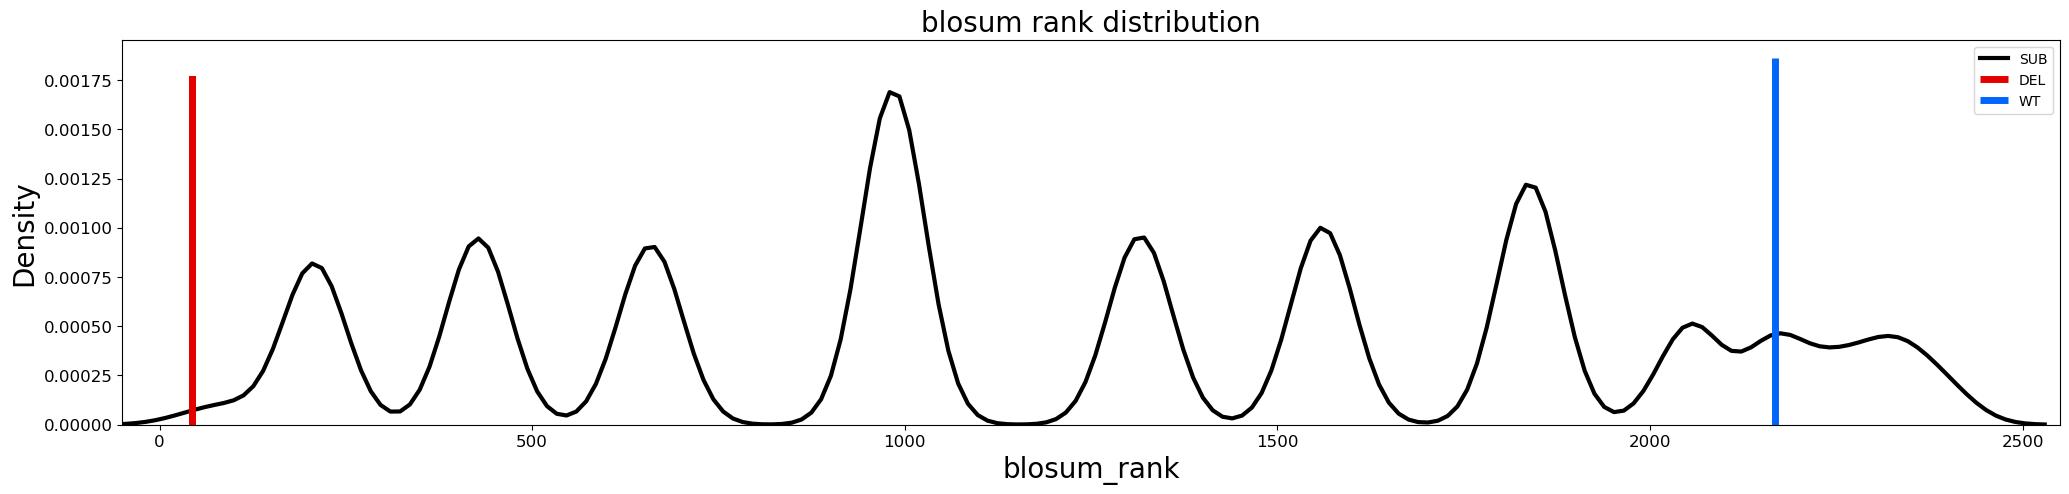

In [9]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='blosum', ax=ax, show_del=False)
plt.show()

BLOSUM public score = 0.196

## pLDDT - 0.292

In [10]:
# Read AlphaFold2 result for wild type sequence:
plddt = (
    pd.read_csv('data/wildtype_structure_prediction_af2.pdb', sep='\s+', header=None)[[0,5,10]]
    .rename(columns={0:'atom', 5:'resid', 10:'plddt'})
    .query('atom=="ATOM"')
    .drop_duplicates()
)

# Add B factor to the testing set:
test_df = pd.merge(
    test_df,
    plddt,
    left_on='resid',
    right_on='resid',
    how='left'
)

test_df['plddt_rank'] = rankdata(-1*test_df['plddt'])

Notice how this method assigns a separate rank to each deletion:

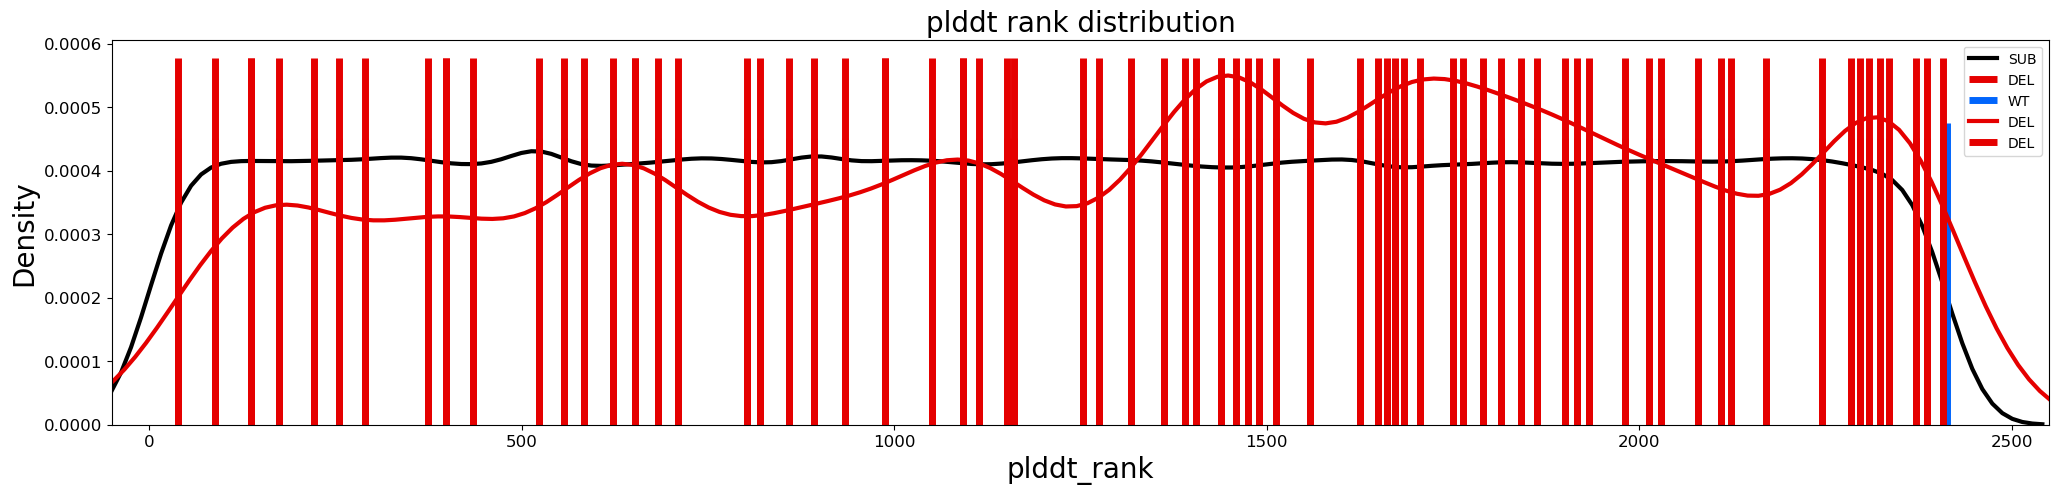

In [11]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='plddt', ax=ax, show_del=True)
plt.show()

pLDDT public score = 0.292

## Differential pLDDT - 0.297

In [12]:
plddtdiff = []

# Wild type result:
wt_plddt = (
    pd.read_csv('data/kvigly-test-mutation-pdbs/WT_unrelaxed_rank_1_model_3.pdb', sep='\s+')
    .loc['ATOM'].reset_index()
    .loc[:, ['level_4', 'MODEL']].drop_duplicates()
    .rename(columns={'level_4':'resid', 'MODEL':'plddt'})
    .astype({'resid':int})
    .set_index('resid')
)

# Add difference in pLDDTto the testing set:>
for _,row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    file_path = 'data/kvigly-test-mutation-pdbs/{}{}{}_unrelaxed_rank_1_model_3.pdb'.format(row['wt'], row['resid'], row['mut'])
    if os.path.exists(file_path):
        tdf = (
            pd.read_csv(file_path, sep='\s+')
            .loc['ATOM'].reset_index()
            .loc[:, ['level_4', 'MODEL']].drop_duplicates()
            .rename(columns={'level_4':'resid', 'MODEL':'plddt'})
            .astype({'resid':int})
            .set_index('resid')
        )
        plddtdiff.append((tdf.loc[row['resid']] - wt_plddt.loc[row['resid']]).values[0])
    else:
        plddtdiff.append(np.nan)

test_df['plddtdiff'] = plddtdiff
test_df['plddtdiff_rank'] = rankdata(test_df['plddtdiff'])

  0%|          | 0/2413 [00:00<?, ?it/s]

In [32]:
wt_plddt

,plddt
resid,
1,44.22
2,51.13
3,30.25
4,37.88
5,34.80
...,...
217,97.64
218,97.44
219,96.87


In [35]:
(tdf.loc[row['resid']] - wt_plddt.loc[row['resid']])

plddt   -5.31
Name: 16, dtype: float64

In [36]:
row['resid']

16

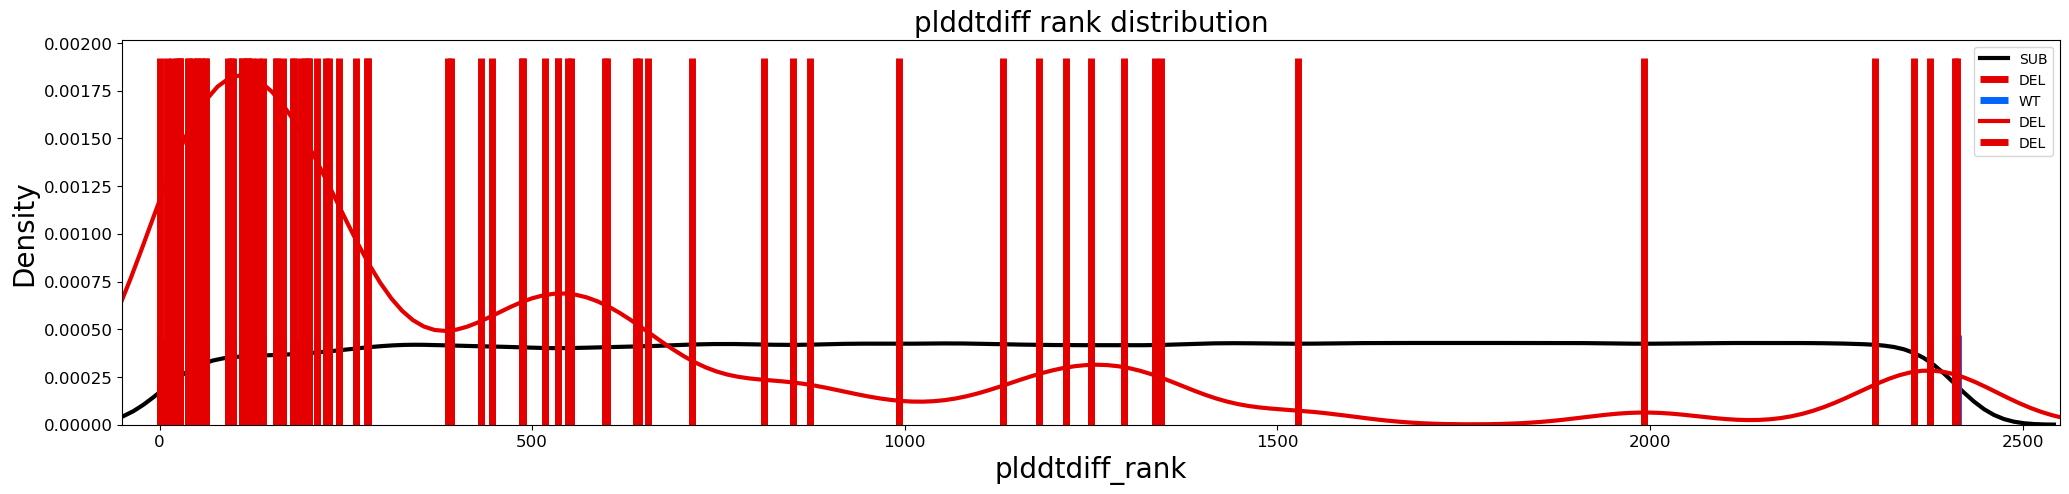

In [13]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='plddtdiff', ax=ax, show_del=True)
plt.show()

Differential pLDDT public score = 0.297

## DeepDDG - 0.361

In [14]:
# Run DeepDDG on http://protein.org.cn/ddg.html by uploading the PDB file and clicking "Submit":>
ddg = pd.read_csv('data/deepddg/ddgout.txt', sep='\s+', usecols=[0,1,2,3,4]).rename(columns={'WT':'wt', 'ResID':'resid', 'Mut':'mut'})

# Add DeepDDG output to the testing set:
test_df = pd.merge(
    test_df.set_index(['wt','resid','mut']),
    ddg.set_index(['wt','resid','mut']),
    left_index=True,
    right_index=True,
    how='left'
).reset_index()

test_df.loc[test_df['type']=='WT','ddG'] = 0
test_df.loc[test_df['type']=='DEL','ddG'] = test_df['ddG'].dropna().median()

test_df['ddG_rank'] = rankdata(test_df['ddG'])

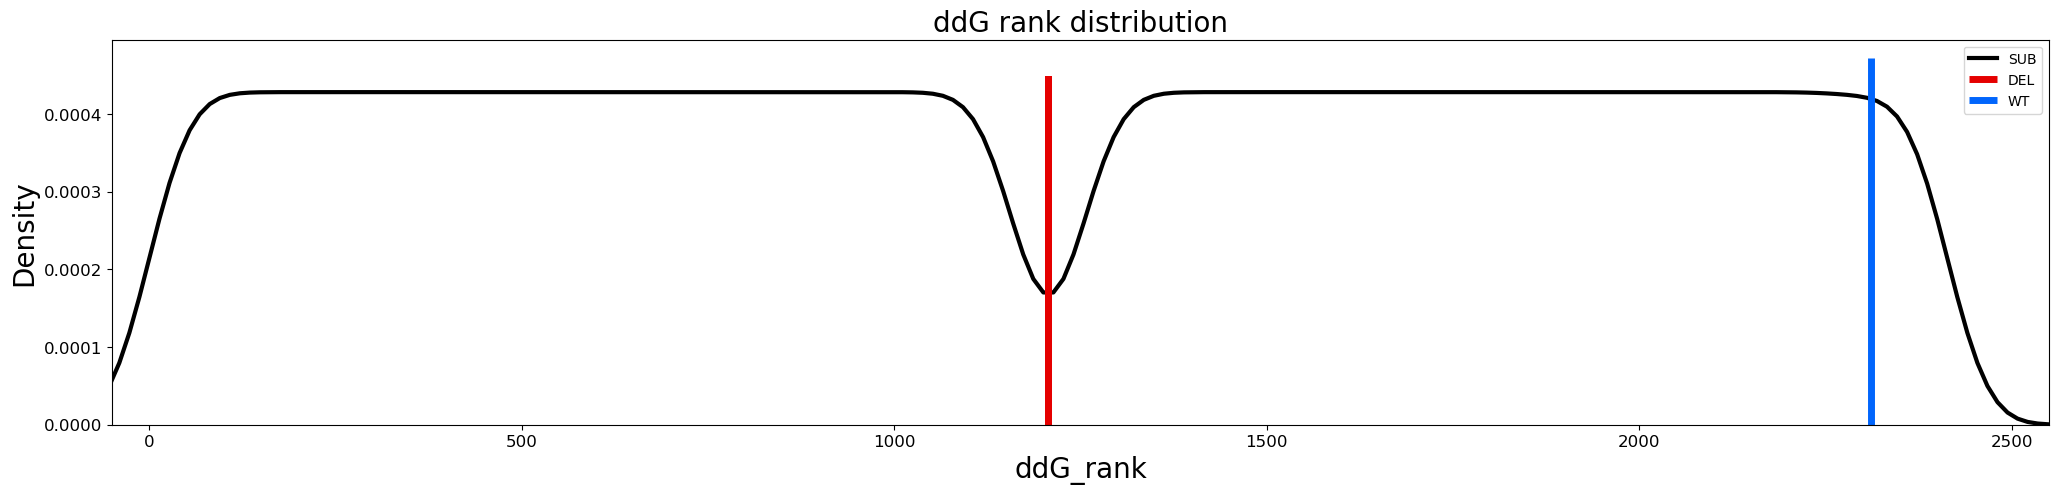

In [15]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='ddG', ax=ax, show_del=False)
plt.show()

DDG public score = 0.361

## DeMaSk - 0.363

In [16]:
# Run DeMaSk on https://demask.princeton.edu/query/ by pasting the wild type sequence and clicking "Compute":
demask = pd.read_csv('data/demask/demaskout.txt', sep='\t', usecols=[0,1,2,3], names=['resid','wt','mut','demask'], skiprows=1)

# Add DeMask output to the testing set:
test_df = pd.merge(
    test_df.set_index(['wt','resid','mut']),
    demask.set_index(['wt','resid','mut']),
    left_index=True,
    right_index=True,
    how='left'
).reset_index()

test_df.loc[test_df['type']=='WT','demask'] = 0
test_df.loc[test_df['type']=='DEL','demask'] = test_df['demask'].dropna().min()


test_df['demask_rank'] = rankdata(test_df['demask'])

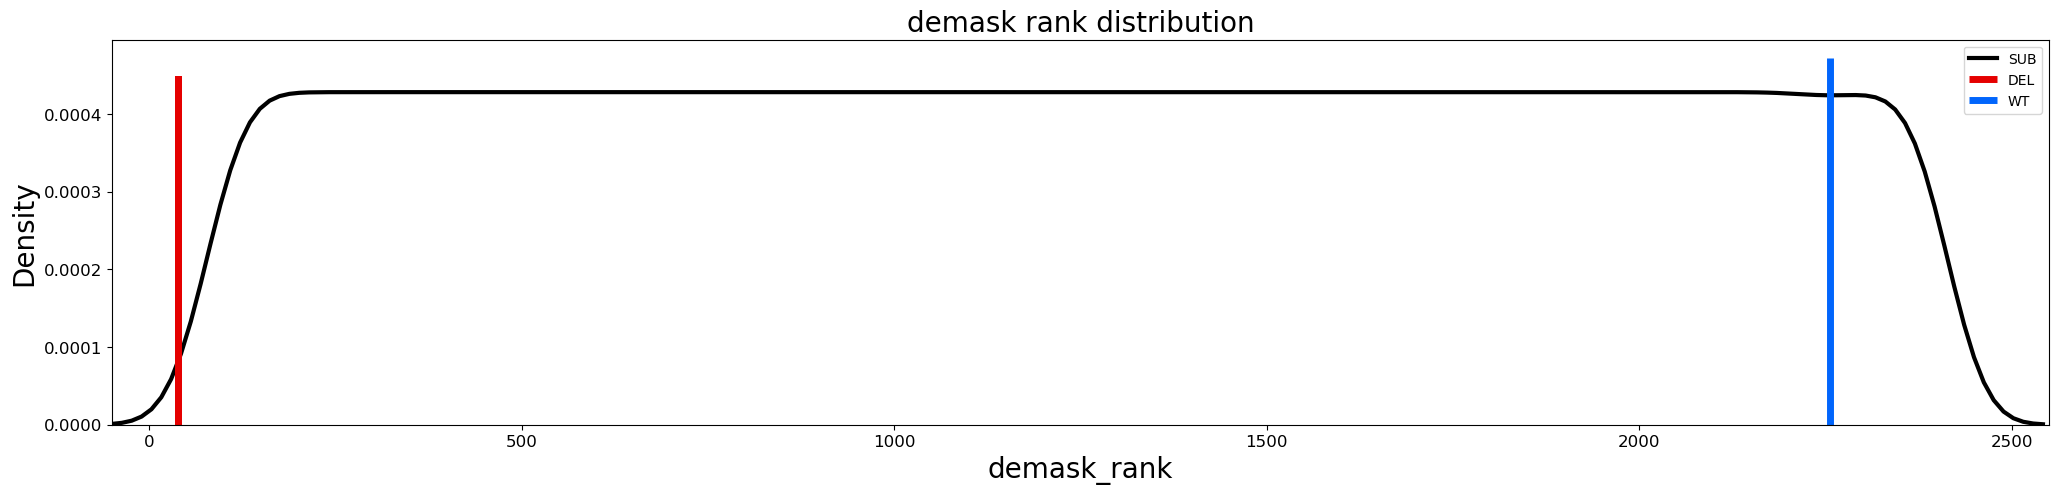

In [17]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='demask', ax=ax, show_del=False)
plt.show()

DeMaSk public score = 0.363

## RMSD - 0.393

In [18]:
# Read VMD/NAMD output:
namd = pd.read_csv('data/md_2/residue_rmsd_sasa_last.dat', sep='\t', header=None, names=['resid','rmsd','sasa0','sasaf'])

# Add VMD/NAMD results to the testing set:
test_df = pd.merge(
    test_df,
    namd[['resid','rmsd']],
    left_on='resid',
    right_on='resid',
    how='left'
)

test_df.loc[test_df['type']=='WT','rmsd'] = test_df['rmsd'].dropna().max()
# test_df.loc[test_df['type']=='WT','sasaf'] = test_df['sasaf'].dropna().max()

test_df['rmsd_rank'] = rankdata(test_df['rmsd'])
# test_df['sasaf_rank'] = rankdata(test_df['sasaf'])

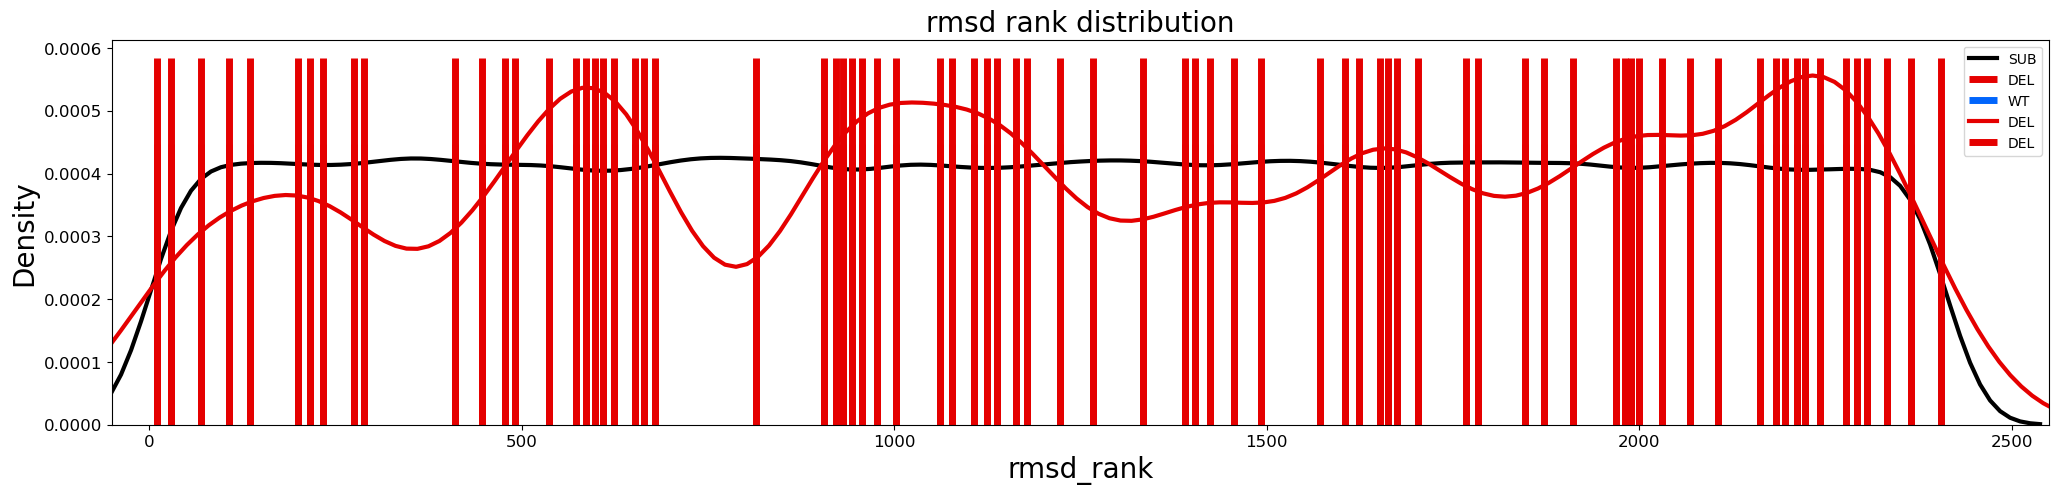

In [19]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='rmsd', ax=ax, show_del=True)
plt.show()

RMSD public score = 0.393

In [20]:
namd

,resid,rmsd,sasa0,sasaf
0,1,1.774145,198.432281,161.419312
1,2,1.656036,116.322868,115.720192
2,3,1.948815,134.644394,150.647171
3,4,2.296046,140.815231,91.828255
4,5,1.398716,119.585098,123.152199
...,...,...,...,...
216,217,0.885676,60.894875,72.163391
217,218,0.925841,97.304672,88.281517
218,219,0.615628,28.972021,41.354168
219,220,0.672172,21.619684,20.294685


## SASA - 0.408

In [21]:
# Read VMD/NAMD output:
namd = pd.read_csv('data/sasa_md/residue_rmsd_sasa_last.dat', sep='\t', header=None, names=['resid','rmsd','sasa0','sasaf'])

# Add VMD/NAMD results to the testing set:
test_df = pd.merge(
    test_df,
    namd[['resid','sasaf']],
    left_on='resid',
    right_on='resid',
    how='left'
)

# test_df.loc[test_df['type']=='WT','rmsd'] = test_df['rmsd'].dropna().max()
test_df.loc[test_df['type']=='WT','sasaf'] = test_df['sasaf'].dropna().max()

# test_df['rmsd_rank'] = rankdata(test_df['rmsd'])
test_df['sasaf_rank'] = rankdata(test_df['sasaf'])

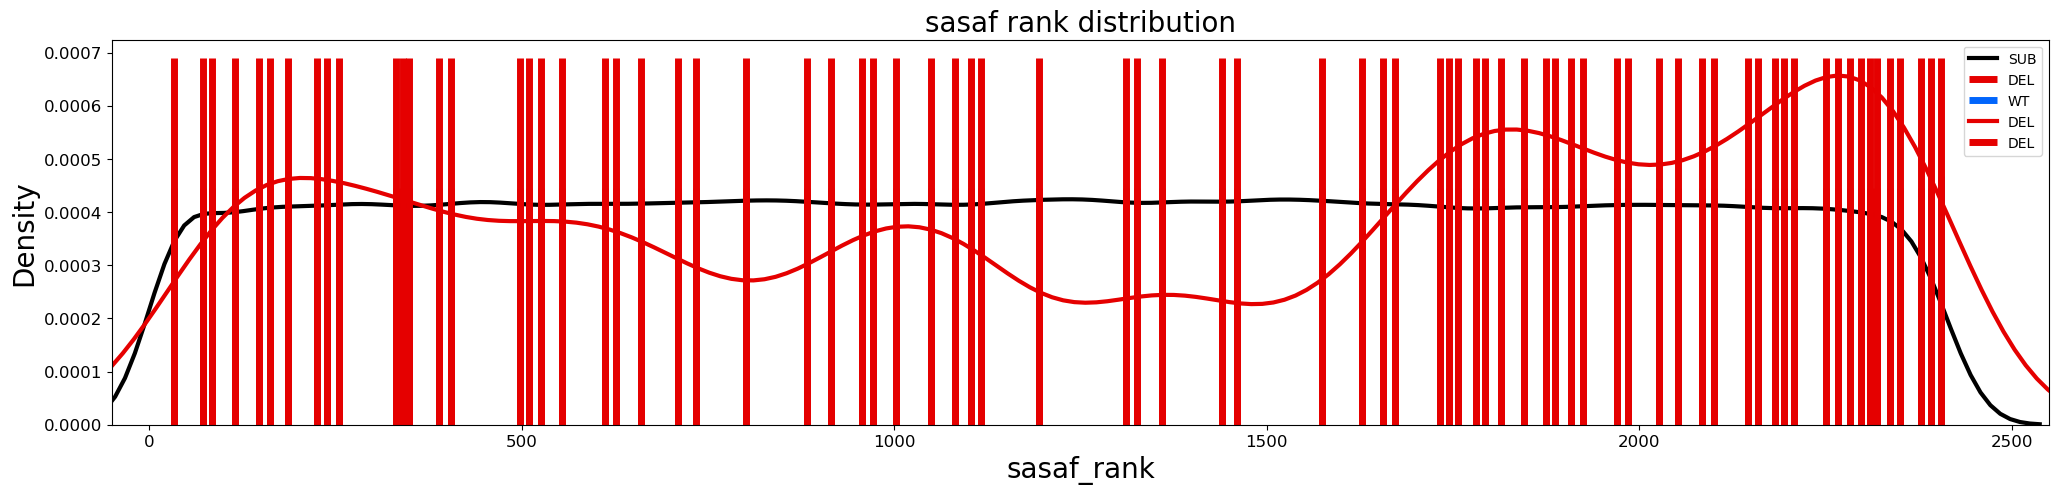

In [22]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='sasaf', ax=ax, show_del=True)
plt.show()

SASA public score = 0.408

## Rosetta - 0.471

In [23]:
test_df['rosetta_rank'] = pd.read_csv('data/rosetta/submission_rosetta_scores')['tm']

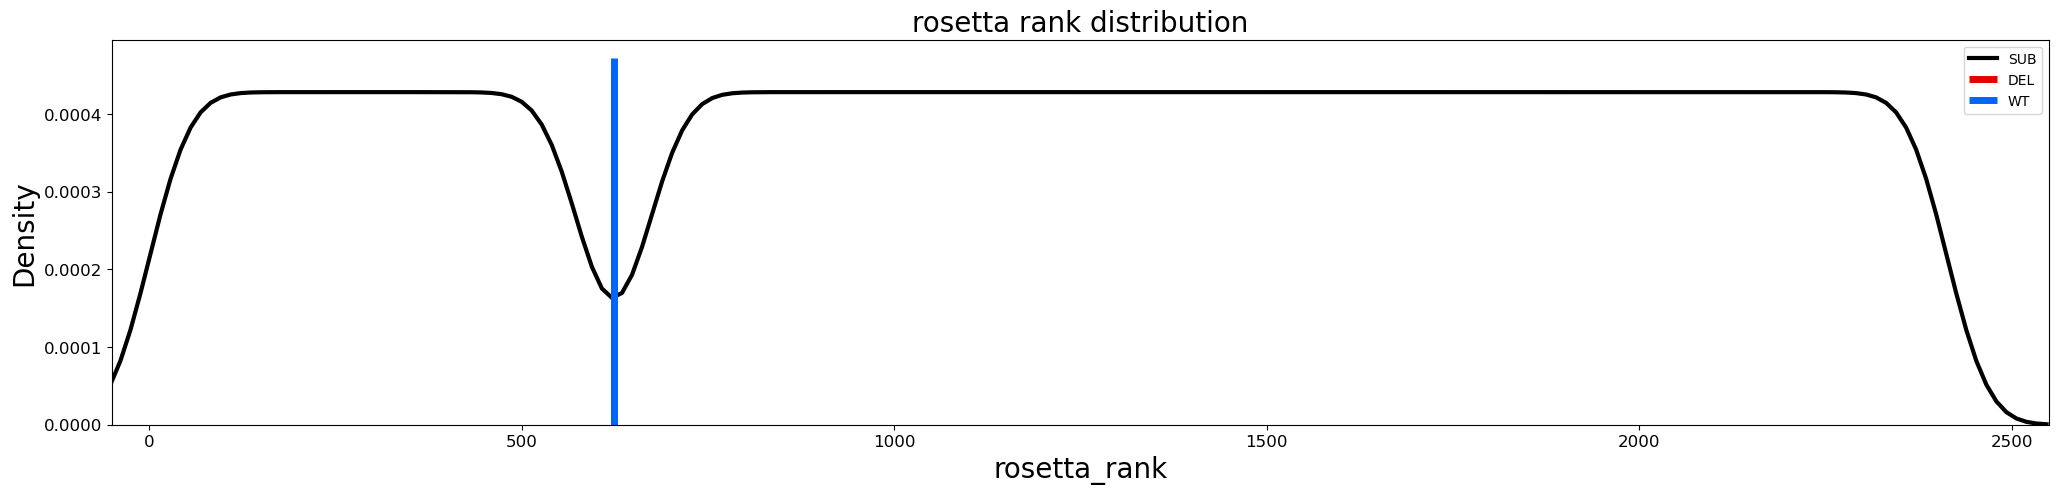

In [24]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='rosetta', ax=ax, show_del=False)
plt.show()

Rosetta public score = 0.471

## Thermonet - 0.494

In [25]:
test_df['thermonet'] = pd.read_csv('data/thermonet/submission.csv')['tm']
test_df['thermonet_rank'] = rankdata(test_df['thermonet'])

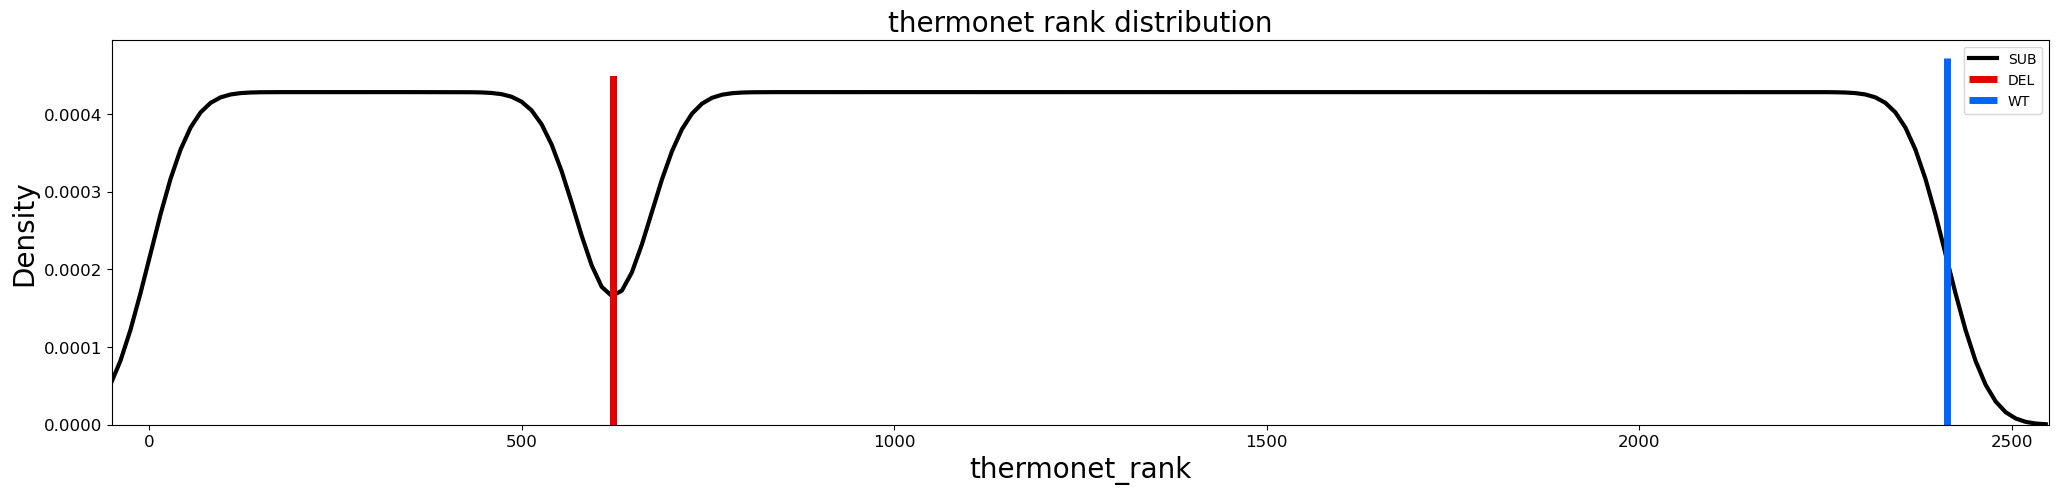

In [26]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='thermonet', ax=ax, show_del=False)
plt.show()

Thermonet public score = 0.494

# Ensembling

In [27]:
def rank_nrom(name):
    s = test_df['{}_rank'.format(name)]
    return s/s.max()

In [28]:
# Scale ranks prior to ensembling:
# Global ensemble:
test_df['tm'] = (
    4 * rank_nrom('rosetta') + 2*rank_nrom('rmsd') + 2*rank_nrom('thermonet') + 2*rank_nrom('plddtdiff') +\
    rank_nrom('sasaf') + rank_nrom('plddt') + rank_nrom('demask') + rank_nrom('ddG') + rank_nrom('blosum')
) / 14

test_df['tm'] = test_df['tm']/test_df['tm'].max()

In [29]:
# Deletion type:
idx = test_df[test_df['type']=="DEL"].index
test_df.loc[idx, 'tm'] =  (2*rank_nrom('plddt')[idx] + 2*rank_nrom('plddtdiff')[idx] + rank_nrom('rmsd')[idx] + rank_nrom('sasaf')[idx]) / 6

# Wild type:
test_df.loc[test_df['type']=="WT",'tm'] = test_df['tm'].max()+1
test_df['tm'] = rankdata(test_df['tm'])
test_df['tm_rank'] = test_df['tm']

# Submission:
test_df[['seq_id','tm']].to_csv('submissions/del_specific_submission.csv', index=False)

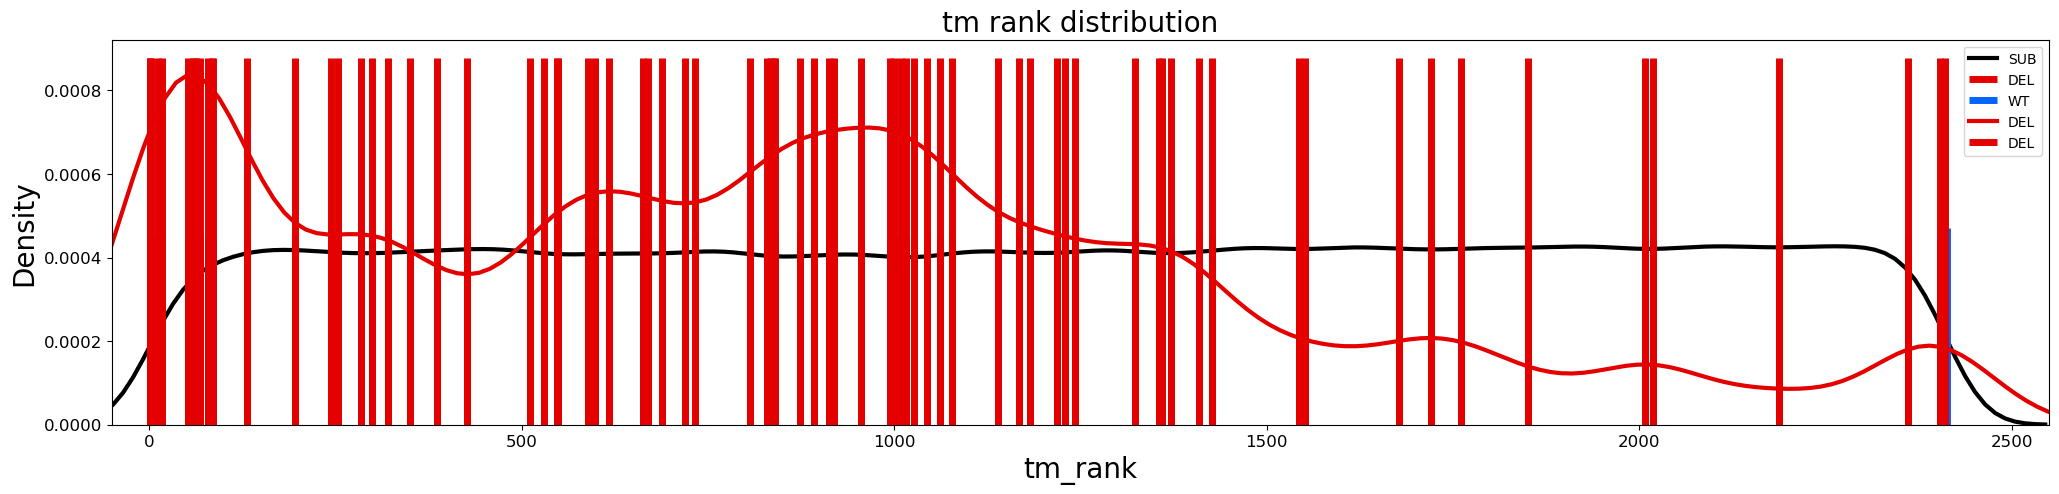

In [30]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='tm', ax=ax, show_del=True)
plt.show()

Thank you for reading!

---

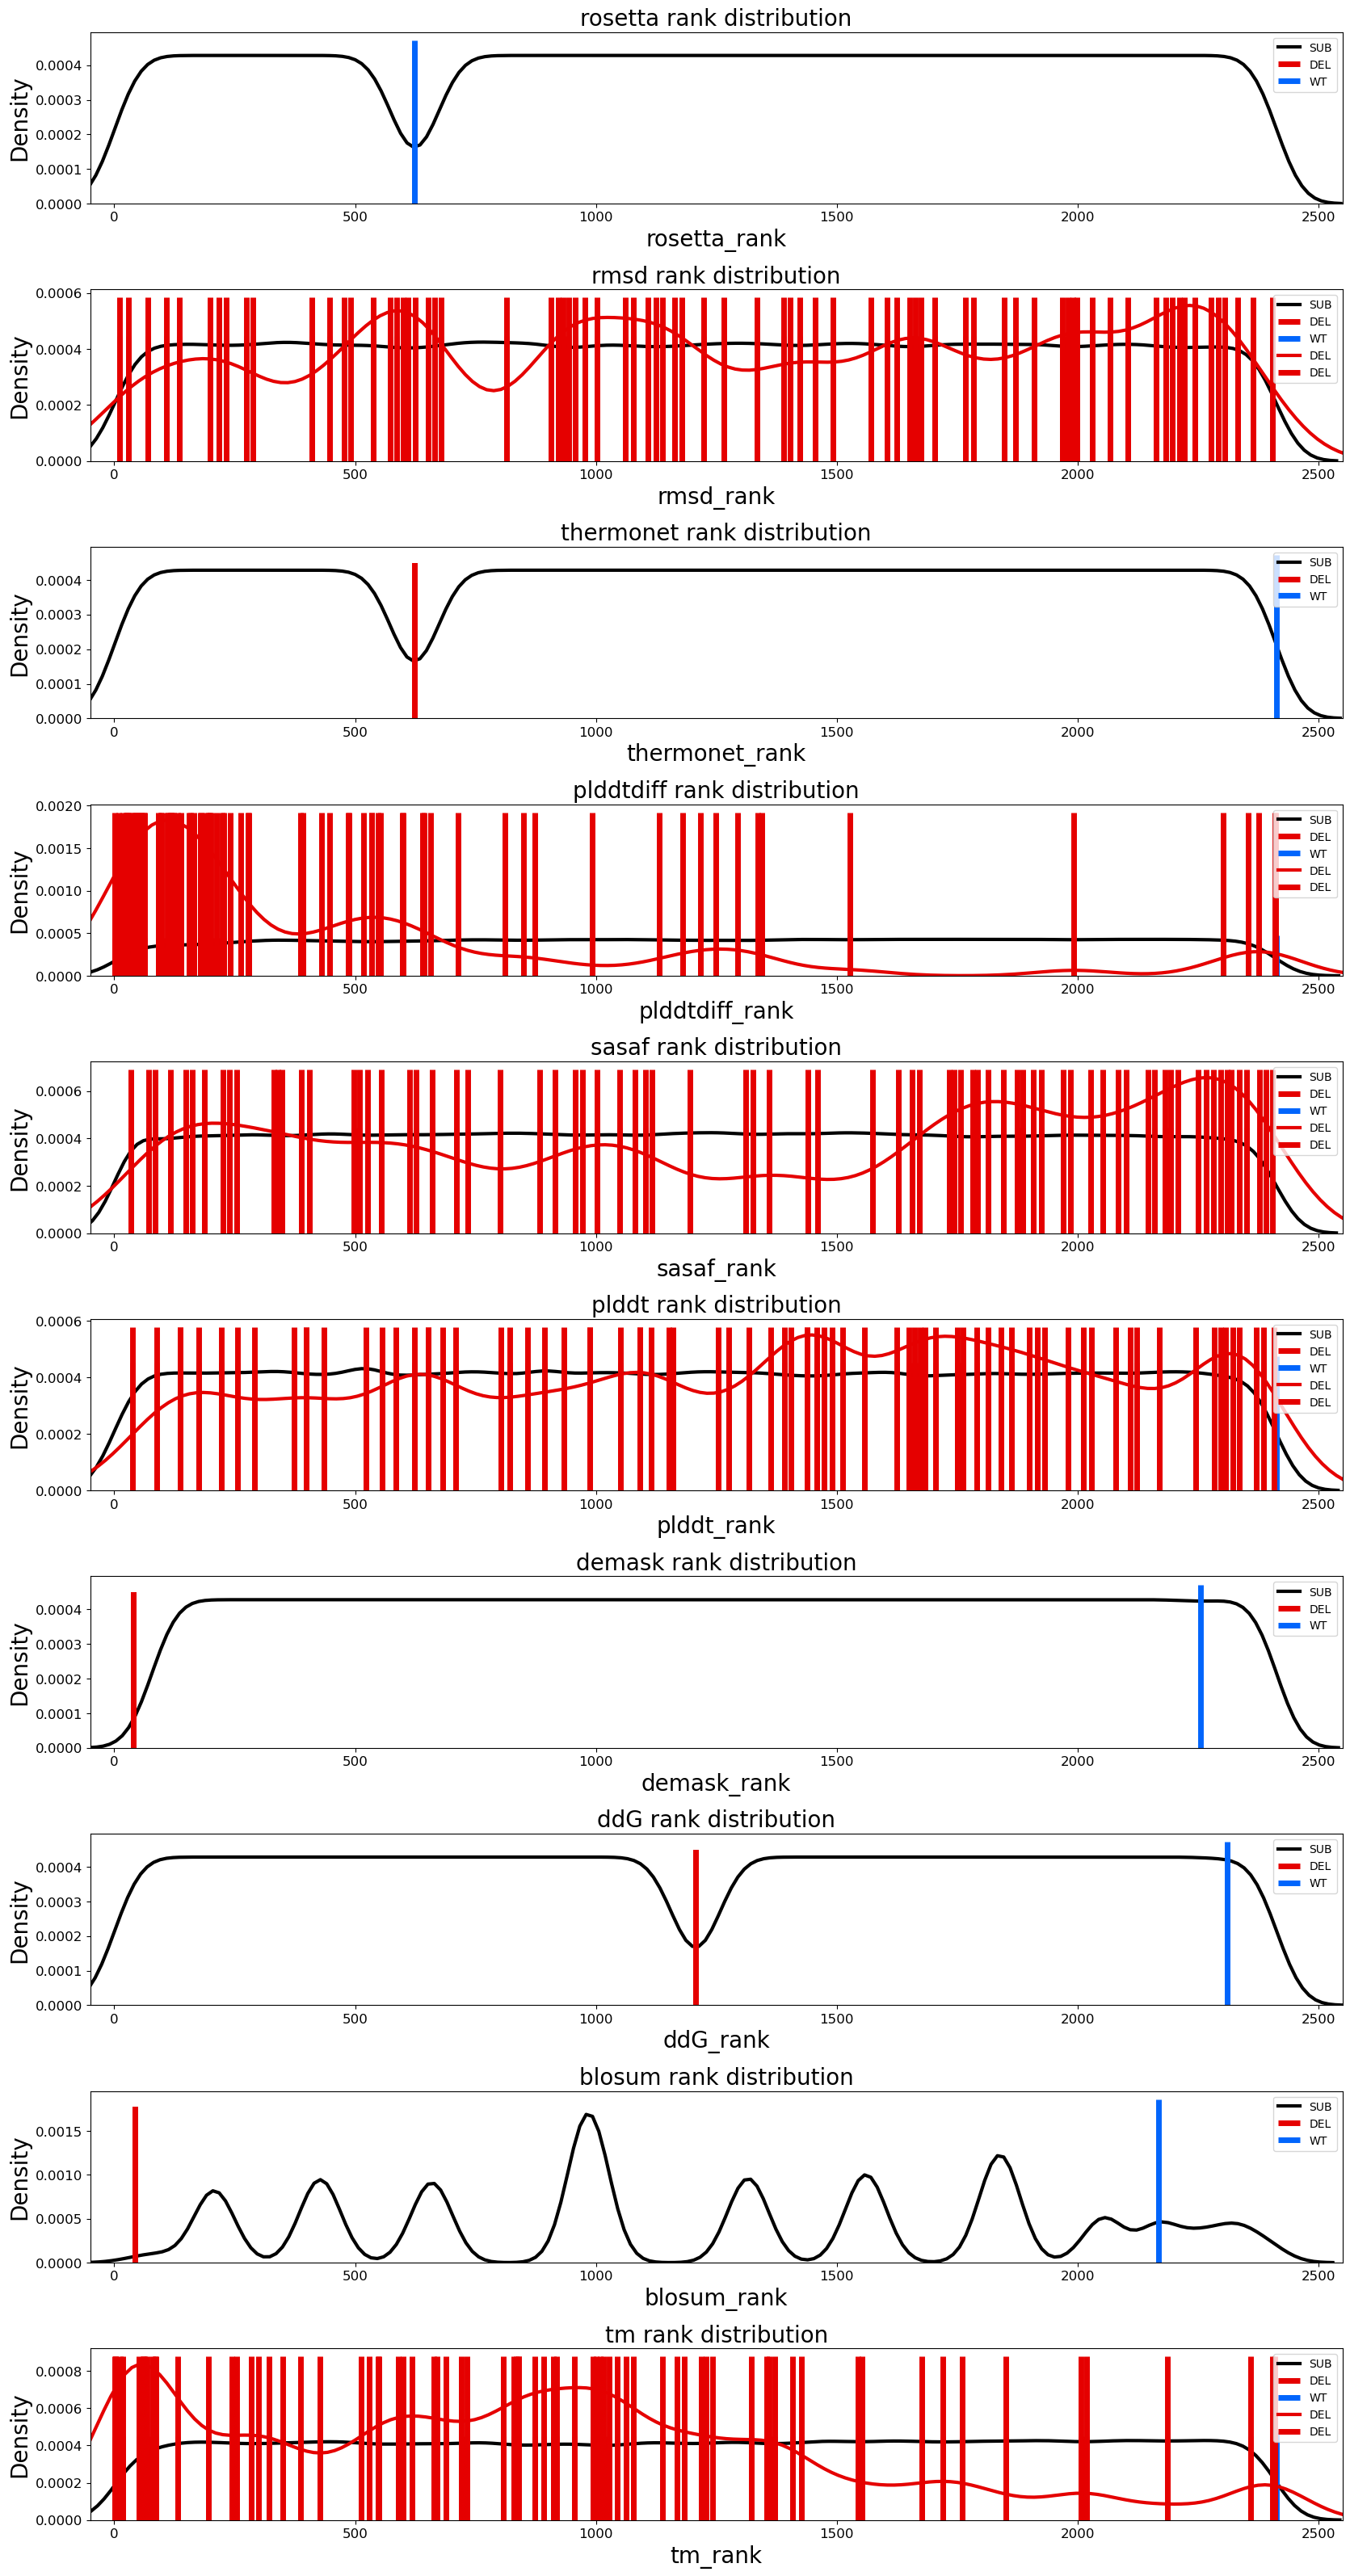

In [31]:
fig, axs = plt.subplots(nrows=10, figsize=(20,40), gridspec_kw={'hspace':0.5})


plot_rank_dist(name='rosetta', ax=axs[0], show_del=False)
plot_rank_dist(name='rmsd', ax=axs[1], show_del=True)
plot_rank_dist(name='thermonet', ax=axs[2], show_del=False)
plot_rank_dist(name='plddtdiff', ax=axs[3], show_del=True)
plot_rank_dist(name='sasaf', ax=axs[4], show_del=True)
plot_rank_dist(name='plddt', ax=axs[5], show_del=True)
plot_rank_dist(name='demask', ax=axs[6], show_del=False)
plot_rank_dist(name='ddG', ax=axs[7], show_del=False)
plot_rank_dist(name='blosum', ax=axs[8], show_del=False)

plot_rank_dist(name='tm', ax=axs[9], show_del=True)

plt.show()